In [1]:
!pip install google-api-python-client google-auth google-auth-oauthlib google-auth-httplib2

In [2]:
!pip install ultralytics
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 11.6 MB/s eta 0:00:0000:010:01


In [3]:
train_download_link = {
    '[원천]bbox(통제환경).zip': ['1AYC3KxZ7iLvlzo5Ad7V2FlCoqtTGdcGM', 'label_bbox_control_env'],
    '[원천]bbox(통제환경)2.zip': ['1a12fATemA050xSrbC448Npsny5uZ0cpt', 'source_bbox_control_env'],
    # '[원천]bbox(실제도로환경).zip': ['1l55vHxiu2HaP8eSS2bj0j8-gZ81GBi75', 'source_bbox_actual_road_env'],
    # '[원천]keypoint(준통제환경).zip': ['1b_mfDu-PYcFzEXj_8SI9O6WCA90wNTCi', 'source_keypoint_semi-control_env'],
    # '[라벨]bbox(실제도로환경).zip': ['13JX_aH4p6Y9WzeG3gNu4yDPa93HyqO7t', 'label_bbox_actual_road_env'],
    # '[라벨]keypoint(준통제환경).zip': ['18q5KsrNGQg-7fClG6bhfx3ueKHq_uf1T', 'label_keypoint_semi-control_env']
}

valid_download_link = {
    # '[라벨]bbox(실제도로환경).zip':  ['1hQzr9_L5WFr46YPmDUoOYZPlohOGva-9', 'label_bbox_actual_road_env'],
    '[라벨]bbox(통제환경).zip': ['1g0xg8jwtKUe9l7XwmLuPftK2hrpuNBK1', 'label_bbox_control_env'],
    # '[라벨]keypoint(준통제환경).zip': ['1BXEn1hPuAcq6vD0rtow8Kd4fgMr9vJw3', 'label_keypoint_semi-control_env'],
    # '[원천]bbox(실제도로환경).zip': ['1rdtttXH03SxRC1EKFLgkFJSgStGnpxty', 'source_bbox_actual_road_env'],
    '[원천]bbox(통제환경).zip': ['1WVlZD-DcgY69zIJZ5KGdPQwsf4sNITXv', 'source_bbox_control_env'],
    # '[원천]keypoint(준통제환경).zip': ['1oYA8U-zLRbKMirO4cC23_mVLrCE-Kn8i', 'source_keypoint_semi-control_env']
}

In [4]:
!pip install gdown
!gdown --id 1X0-m7k3mMcbt-XtiLI4Oqvrv8bV4rXRS

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1X0-m7k3mMcbt-XtiLI4Oqvrv8bV4rXRS
To: /kaggle/working/credentials.json
100%|██████████████████████████████████████| 2.37k/2.37k [00:00<00:00, 11.8MB/s]


In [ ]:
import os
import io
import zipfile
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from tqdm import tqdm  # For progress bar

def get_drive_service(credentials_path):
    # Load credentials from the JSON file
    credentials = service_account.Credentials.from_service_account_file(
        credentials_path,
        scopes=["https://www.googleapis.com/auth/drive.readonly"]
    )
    return build("drive", "v3", credentials=credentials)

def process_file(service, file_id, zip_path):
    """Download, extract, and delete a single ZIP file"""
    try:
        # 1. Download the file
        print(f"\nDownloading {os.path.basename(zip_path)}...")
        request = service.files().get_media(fileId=file_id)
        with io.FileIO(zip_path, "wb") as fh:
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            with tqdm(total=100, desc="Downloading", unit="%") as pbar:
                while not done:
                    status, done = downloader.next_chunk()
                    pbar.update(int(status.progress() * 100) - pbar.n)

        # 2. Extract contents
        print(f"Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(zip_path))

        # 3. Delete ZIP to free space
        os.remove(zip_path)
        print(f"Successfully processed and deleted {zip_path}")
        return True

    except Exception as e:
        print(f"Error processing file: {str(e)}")
        # Clean up any partial files
        if os.path.exists(zip_path):
            os.remove(zip_path)
        return False

def process_dataset(download_links, parent_folder, credentials_path):
    service = get_drive_service(credentials_path)

    for filename, (file_id, folder_name) in download_links.items():
        target_dir = os.path.join(parent_folder, folder_name)
        os.makedirs(target_dir, exist_ok=True)
        zip_path = os.path.join(target_dir, filename)

        # Skip if already extracted
        if os.listdir(target_dir) and not filename.endswith('.zip'):
            print(f"Skipping {filename} - already extracted")
            continue

        # Process file with space management
        if process_file(service, file_id, zip_path):
            print(f"Completed processing {filename}")
        else:
            print(f"Failed to process {filename}")

# Example usage
credentials_path = "/kaggle/working/credentials.json"  # Path to your credentials.json file

# Process datasets sequentially
process_dataset(train_download_link, "dataset/train", credentials_path)
process_dataset(valid_download_link, "dataset/valid", credentials_path)

Downloading: 100%|██████████| 100/100 [00:32<00:00,  3.06%/s]


Extracting dataset/train/label_bbox_control_env/[원천]bbox(통제환경).zip...
Successfully processed and deleted dataset/train/label_bbox_control_env/[원천]bbox(통제환경).zip
Completed processing [원천]bbox(통제환경).zip



Downloading:  36%|███▌      | 36/100 [02:03<03:53,  3.64s/%]

In [6]:
import os
import statistics
from collections import defaultdict
from tabulate import tabulate

def get_general_dataset_info(parent_folder):
    folder_summary = []

    # Loop through all directories in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        if os.path.isdir(folder_path):
            total_subfolders = 0
            total_files = 0
            subfolder_counts = []
            file_types = defaultdict(int) 

            for root, dirs, files in os.walk(folder_path):
                # Count subfolders
                if root == folder_path:
                    total_subfolders = len(dirs)

                for file in files:
                    file_type = file.split('.')[-1]
                    file_types[file_type] += 1
                subfolder_counts.append(len(files))
                total_files += len(files)

            # Calculate the average, min, max, standard deviation file count per folder
            avg_files_per_subfolder = total_files / total_subfolders if total_subfolders else 0
            min_files_in_subfolder = min(subfolder_counts) if subfolder_counts else 0
            max_files_in_subfolder = max(subfolder_counts) if subfolder_counts else 0
            stdev_files_per_subfolder = statistics.stdev(subfolder_counts) if len(subfolder_counts) > 1 else 0

            # Add the summary for this folder
            folder_summary.append({
                "Folder": folder_name,
                "Total": total_subfolders,
                "Avg_cnt": avg_files_per_subfolder,
                "Min_cnt": min_files_in_subfolder,
                "Max_cnt": max_files_in_subfolder,
                "std": stdev_files_per_subfolder,
                "Total Files": total_files,
                "File Types": dict(file_types)  # Convert to a regular dictionary for easier readability
            })

    return folder_summary

def display_side_by_side_tables(train_summary, valid_summary):
    headers = ["Folder", "Total", "Avg_cnt",
               "Min_cnt", "Max_cnt", "std",
               "Total Files", "File Types"]

    # Tabulate data for 'train' and 'valid' side by side
    train_table = [list(summary.values()) for summary in train_summary]
    valid_table = [list(summary.values()) for summary in valid_summary]

    # Print tables side by side
    print("General Dataset Information (Train vs. Valid):")
    print(f"\n{tabulate(train_table, headers, tablefmt='grid')}")
    print(f"\n{tabulate(valid_table, headers, tablefmt='grid')}")


# Example usage
train_summary = get_general_dataset_info('dataset/train')
valid_summary = get_general_dataset_info('dataset/valid')

display_side_by_side_tables(train_summary, valid_summary)

General Dataset Information (Train vs. Valid):

+-------------------------+---------+-----------+-----------+-----------+---------+---------------+------------------+
| Folder                  |   Total |   Avg_cnt |   Min_cnt |   Max_cnt |     std |   Total Files | File Types       |
+=========================+=========+===========+===========+===========+=========+===============+==================+
| source_bbox_control_env |     216 |   464.366 |         0 |       490 | 43.6172 |        100303 | {'jpg': 100303}  |
+-------------------------+---------+-----------+-----------+-----------+---------+---------------+------------------+
| label_bbox_control_env  |     216 |   464.366 |         0 |       490 | 43.6172 |        100303 | {'json': 100303} |
+-------------------------+---------+-----------+-----------+-----------+---------+---------------+------------------+

+-------------------------+---------+-----------+-----------+-----------+---------+---------------+-----------------+


In [7]:
import os
import json
from tabulate import tabulate

counts_train = {
    "Cigar": 0,
    "Mouth": 0,
    "Phone": 0,
    "Reye": 0,
    "Leye": 0,
    "Mask": 0,
    "Glass": 0,
    "Cap": 0
}

counts_valid = {
    "Cigar": 0,
    "Mouth": 0,
    "Phone": 0,
    "Reye": 0,
    "Leye": 0,
    "Mask": 0,
    "Glass": 0,
    "Cap": 0
}

def count_groups_in_json(file_path, counts):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            if data["ObjectInfo"]["BoundingBox"]["Cigar"]["isVisible"]:
                counts["Cigar"] += 1
            if data["ObjectInfo"]["BoundingBox"]["Mouth"]["isVisible"]:
                counts["Mouth"] += 1
            if data["ObjectInfo"]["BoundingBox"]["Phone"]["isVisible"]:
                counts["Phone"] += 1
            if data["ObjectInfo"]["BoundingBox"]["Reye"]["isVisible"]:
                counts["Reye"] += 1
            if data["ObjectInfo"]["BoundingBox"]["Leye"]["isVisible"]:
                counts["Leye"] += 1
            if data["Accessory"].get("Mask", False):
                counts["Mask"] += 1
            if data["Accessory"].get("Glasses", False):
                counts["Glass"] += 1
            if data["Accessory"].get("Cap", False):
                counts["Cap"] += 1
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

def process_directory(base_path, counts):
    for root, dirs, files in os.walk(base_path):
        for filename in files:
            if filename.endswith(".json"):
                file_path = os.path.join(root, filename)
                count_groups_in_json(file_path, counts)

train_dir = "dataset/train"
valid_dir = "dataset/valid"

process_directory(train_dir, counts_train)
process_directory(valid_dir, counts_valid)

table_train = [[group, count] for group, count in counts_train.items()]
table_valid = [[group, count] for group, count in counts_valid.items()]

print()
print()
print("Training set:")
print(tabulate(table_train, headers=["Group", "Count"], tablefmt="pretty"))

print()
print()
print("Validation set:")
print(tabulate(table_valid, headers=["Group", "Count"], tablefmt="pretty"))



Training set:
+-------+-------+
| Group | Count |
+-------+-------+
| Cigar | 11281 |
| Mouth | 70313 |
| Phone | 11173 |
| Reye  | 91719 |
| Leye  | 97428 |
| Mask  | 21834 |
| Glass | 57686 |
|  Cap  | 40039 |
+-------+-------+


Validation set:
+-------+-------+
| Group | Count |
+-------+-------+
| Cigar | 1254  |
| Mouth | 8731  |
| Phone | 1445  |
| Reye  | 11457 |
| Leye  | 12236 |
| Mask  | 2831  |
| Glass | 7587  |
|  Cap  | 5110  |
+-------+-------+


In [8]:
import os
import shutil

# Define paths
original_dataset_path = "dataset"
new_dataset_path = "new_dataset"

# Create new directories
all_images_dir = os.path.join(new_dataset_path, "all_images")
all_labels_dir = os.path.join(new_dataset_path, "all_labels")
os.makedirs(all_images_dir, exist_ok=True)
os.makedirs(all_labels_dir, exist_ok=True)

def move_files_safely(src_dir, dest_dir, file_extension):
    """Move files from source to destination, renaming duplicates"""
    for root, _, files in os.walk(src_dir):
        for file in files:
            if file.endswith(file_extension):
                src_path = os.path.join(root, file)

                # Create unique filename if duplicate exists
                base, ext = os.path.splitext(file)
                dest_name = file
                counter = 1
                while os.path.exists(os.path.join(dest_dir, dest_name)):
                    dest_name = f"{base}_{counter}{ext}"
                    counter += 1

                # Move the file
                dest_path = os.path.join(dest_dir, dest_name)
                shutil.move(src_path, dest_path)
    print(f"Moved {file_extension} files from {src_dir} to {dest_dir}")

# Process both train and valid data
for split in ["train", "valid"]:
      for source_type in ["source_bbox_actual_road_env", "source_bbox_control_env", "source_keypoint_semi-control_env"]:
          src_dir = os.path.join(original_dataset_path, split, source_type)
          move_files_safely(src_dir, all_images_dir, ".jpg")
          # Move labels from both label directories
      for label_type in ["label_bbox_actual_road_env", "label_bbox_control_env", "label_keypoint_semi-control_env", ]:
          src_dir = os.path.join(original_dataset_path, split, label_type)
          move_files_safely(src_dir, all_labels_dir, ".json")


print("Reorganization complete! All files moved to:")
print(f"- Images: {all_images_dir}")
print(f"- Labels: {all_labels_dir}")

Moved .jpg files from dataset/train/source_bbox_actual_road_env to new_dataset/all_images
Moved .jpg files from dataset/train/source_bbox_control_env to new_dataset/all_images
Moved .jpg files from dataset/train/source_keypoint_semi-control_env to new_dataset/all_images
Moved .json files from dataset/train/label_bbox_actual_road_env to new_dataset/all_labels
Moved .json files from dataset/train/label_bbox_control_env to new_dataset/all_labels
Moved .json files from dataset/train/label_keypoint_semi-control_env to new_dataset/all_labels
Moved .jpg files from dataset/valid/source_bbox_actual_road_env to new_dataset/all_images
Moved .jpg files from dataset/valid/source_bbox_control_env to new_dataset/all_images
Moved .jpg files from dataset/valid/source_keypoint_semi-control_env to new_dataset/all_images
Moved .json files from dataset/valid/label_bbox_actual_road_env to new_dataset/all_labels
Moved .json files from dataset/valid/label_bbox_control_env to new_dataset/all_labels
Moved .json

In [9]:
import os

def count_files(directory):
    # Count only files (ignoring subdirectories, if any)
    return sum(1 for entry in os.listdir(directory) if os.path.isfile(os.path.join(directory, entry)))

# Define folder paths
images_dir = 'new_dataset/all_images'
labels_dir = 'new_dataset/all_labels'

# Count the files in each folder
images_count = count_files(images_dir)
labels_count = count_files(labels_dir)

# Print the results
print(f"Number of image files: {images_count}")
print(f"Number of label files: {labels_count}")


Number of image files: 112866
Number of label files: 112866


In [10]:
# import os
# import json
# import random
# import shutil
# from collections import defaultdict

# SOURCE_IMAGES = "new_dataset/all_images"
# SOURCE_LABELS = "new_dataset/all_labels"
# DEST_BASE = "stratified_dataset"

# SPLIT_RATIOS = {"train": 0.8, "valid": 0.15, "test": 0.05}
# CATEGORIES = ["Cigar", "Phone", "Mask", "Glass", "Cap"]
# BATCH_SIZE = 1000


# def is_segmentation(data):
#     """Check if the data represents segmentation (face not visible)."""
#     face_visible = data.get("ObjectInfo", {}).get("BoundingBox", {}).get("Face", {}).get("isVisible", False)
#     return not face_visible


# def is_cigar_or_phone(data):
#     """Check if the data contains a visible cigar or phone."""
#     cigar = data.get("ObjectInfo", {}).get("BoundingBox", {}).get("Cigar", {}).get("isVisible", False)
#     phone = data.get("ObjectInfo", {}).get("BoundingBox", {}).get("Phone", {}).get("isVisible", False)
#     return cigar or phone


# def validate_dataset():
#     """Validate the dataset and filter valid pairs."""
#     images = {os.path.splitext(f)[0] for f in os.listdir(SOURCE_IMAGES) if f.endswith(".jpg")}
#     labels = {os.path.splitext(f)[0] for f in os.listdir(SOURCE_LABELS) if f.endswith(".json")}

#     missing_labels = images - labels
#     orphan_labels = labels - images

#     if missing_labels:
#         print(f"Warning: {len(missing_labels)} images are missing labels.")
#     if orphan_labels:
#         print(f"Warning: {len(orphan_labels)} labels have no corresponding images.")

#     valid_pairs = list(images & labels)
#     filtered_pairs = []
#     segmentation_count = 0
#     non_cigar_phone_count = 0

#     for base in valid_pairs:
#         label_path = os.path.join(SOURCE_LABELS, f"{base}.json")
#         try:
#             with open(label_path, "r") as f:
#                 data = json.load(f)

#             if is_segmentation(data):
#                 segmentation_count += 1
#                 continue

#             if not is_cigar_or_phone(data):
#                 non_cigar_phone_count += 1
#                 continue

#             filtered_pairs.append(base)
#         except Exception as e:
#             #print(f"Error processing {base}: {e}")
#             pass

#     print(f"Filtered pairs: {len(filtered_pairs)}")
#     print(f"Skipped due to segmentation: {segmentation_count}")
#     print(f"Skipped due to non-cigar/phone: {non_cigar_phone_count}")
#     return filtered_pairs


# def get_image_categories(base_name):
#     """Extract categories from JSON file with error handling."""
#     label_path = os.path.join(SOURCE_LABELS, f"{base_name}.json")
#     try:
#         with open(label_path, "r") as f:
#             data = json.load(f)
#     except Exception as e:
#         print(f"Error loading {label_path}: {e}")
#         return []

#     categories = []
#     # Extract bounding box categories
#     bbox = data.get("ObjectInfo", {}).get("BoundingBox", {})
#     for cat in ["Cigar", "Phone"]:
#         if bbox.get(cat, {}).get("isVisible", False):
#             categories.append(cat)

#     # Extract accessory categories
#     accessories = data.get("Accessory", {})
#     for cat, key in [("Mask", "Mask"), ("Glass", "Glasses"), ("Cap", "Cap")]:
#         if accessories.get(key, False):
#             categories.append(cat)

#     return categories if categories else ["None"]


# def create_stratified_splits(valid_pairs):
#     """Create stratified splits based on categories."""
#     category_index = defaultdict(list)
#     all_samples = set(valid_pairs)

#     for base in valid_pairs:
#         categories = get_image_categories(base)
#         for cat in categories:
#             category_index[cat].append(base)

#     for cat in category_index:
#         random.shuffle(category_index[cat])

#     splits = {
#         "train": set(),
#         "valid": set(),
#         "test": set()
#     }

#     for cat in sorted(category_index, key=lambda x: len(category_index[x])):
#         items = [x for x in category_index[cat] if x in all_samples]
#         total = len(items)

#         if total == 0:
#             continue

#         train_end = int(total * SPLIT_RATIOS["train"])
#         valid_end = train_end + int(total * SPLIT_RATIOS["valid"])

#         splits["train"].update(items[:train_end])
#         all_samples -= splits["train"]

#         splits["valid"].update(items[train_end:valid_end])
#         all_samples -= splits["valid"]

#         splits["test"].update(items[valid_end:])
#         all_samples -= splits["test"]

#     splits["test"].update(all_samples)

#     return {
#         "train": list(splits["train"]),
#         "valid": list(splits["valid"]),
#         "test": list(splits["test"])
#     }


# def safe_file_transfer(split_files, split_name):
#     """Transfer files with validation and error logging."""
#     moved = {"images": 0, "labels": 0}
#     errors = {"images": 0, "labels": 0}

#     os.makedirs(os.path.join(DEST_BASE, split_name, "images"), exist_ok=True)
#     os.makedirs(os.path.join(DEST_BASE, split_name, "labels"), exist_ok=True)

#     for base in split_files:
#         img_src = os.path.join(SOURCE_IMAGES, f"{base}.jpg")
#         img_dest = os.path.join(DEST_BASE, split_name, "images", f"{base}.jpg")
#         try:
#             if os.path.exists(img_src):
#                 shutil.move(img_src, img_dest)
#                 moved["images"] += 1
#             else:
#                 errors["images"] += 1
#         except Exception as e:
#             errors["images"] += 1

#         label_src = os.path.join(SOURCE_LABELS, f"{base}.json")
#         label_dest = os.path.join(DEST_BASE, split_name, "labels", f"{base}.json")
#         try:
#             if os.path.exists(label_src):
#                 shutil.move(label_src, label_dest)
#                 moved["labels"] += 1
#             else:
#                 errors["labels"] += 1
#         except Exception as e:
#             errors["labels"] += 1

#     return moved, errors


# def generate_report(final_splits):
#     """Generate detailed stratification report."""
#     report = {}
#     for split in SPLIT_RATIOS:
#         split_data = {
#             "total": len(final_splits[split]),
#             "categories": defaultdict(int)
#         }

#         for base in final_splits[split]:
#             label_path = os.path.join(DEST_BASE, split, "labels", f"{base}.json")
#             categories = get_image_categories(base)
#             for cat in categories:
#                 split_data["categories"][cat] += 1

#         report[split] = split_data

#     return report


# if __name__ == "__main__":
#     valid_pairs = validate_dataset()
#     print(f"Total valid pairs: {len(valid_pairs)}")
#     if not valid_pairs:
#         exit("No valid pairs to process")

#     final_splits = create_stratified_splits(valid_pairs)

#     total_moved = defaultdict(int)
#     total_errors = defaultdict(int)

#     for split in SPLIT_RATIOS:
#         split_files = final_splits[split]
#         for i in range(0, len(split_files), BATCH_SIZE):
#             batch = split_files[i:i + BATCH_SIZE]
#             moved, errors = safe_file_transfer(batch, split)
#             for k in moved:
#                 total_moved[k] += moved[k]
#             for k in errors:
#                 total_errors[k] += errors[k]

#     report = generate_report(final_splits)

#     # Final summary
#     print("\n🚀 Operation Summary")
#     print(f"Successfully moved:")
#     print(f"  - Images: {total_moved['images']}")
#     print(f"  - Labels: {total_moved['labels']}")
#     print(f"Errors encountered:")
#     print(f"  - Missing images: {total_errors['images']}")
#     print(f"  - Missing labels: {total_errors['labels']}")

In [11]:
import os
import json
import random
import shutil
from collections import defaultdict

SOURCE_IMAGES = "new_dataset/all_images"
SOURCE_LABELS = "new_dataset/all_labels"
DEST_BASE = "stratified_dataset"

SPLIT_RATIOS = {"train": 0.8, "valid": 0.15, "test": 0.05}
CATEGORIES = ["Cigar", "Phone", "Mask", "Glass", "Cap"]
BATCH_SIZE = 1000

CLASS_MAP = {
    "Face": 0,
    "Eye_Open": 1,
    "Eye_Close": 2,
    "Mouth_Open": 3,
    "Mouth_Close": 4,
    "Cigar": 5,
    "Phone": 6
}

def is_segmentation(data):
    """Check if the data represents segmentation (face not visible)."""
    face_visible = data.get("ObjectInfo", {}).get("BoundingBox", {}).get("Face", {}).get("isVisible", False)
    return not face_visible


def is_cigar_or_phone(data):
    """Check if the data contains a visible cigar or phone."""
    cigar = data.get("ObjectInfo", {}).get("BoundingBox", {}).get("Cigar", {}).get("isVisible", False)
    phone = data.get("ObjectInfo", {}).get("BoundingBox", {}).get("Phone", {}).get("isVisible", False)
    return cigar or phone


def validate_dataset():
    """Validate the dataset and filter valid pairs."""
    images = {os.path.splitext(f)[0] for f in os.listdir(SOURCE_IMAGES) if f.endswith(".jpg")}
    labels = {os.path.splitext(f)[0] for f in os.listdir(SOURCE_LABELS) if f.endswith(".json")}

    missing_labels = images - labels
    orphan_labels = labels - images

    if missing_labels:
        print(f"Warning: {len(missing_labels)} images are missing labels.")
    if orphan_labels:
        print(f"Warning: {len(orphan_labels)} labels have no corresponding images.")

    valid_pairs = list(images & labels)
    filtered_pairs = []
    segmentation_count = 0
    non_cigar_phone_count = 0

    for base in valid_pairs:
        label_path = os.path.join(SOURCE_LABELS, f"{base}.json")
        try:
            with open(label_path, "r") as f:
                data = json.load(f)

            if is_segmentation(data):
                segmentation_count += 1
                continue

            if not is_cigar_or_phone(data):
                non_cigar_phone_count += 1
                continue

            filtered_pairs.append(base)
        except Exception as e:
            #print(f"Error processing {base}: {e}")
            pass

    print(f"Filtered pairs: {len(filtered_pairs)}")
    print(f"Skipped due to segmentation: {segmentation_count}")
    print(f"Skipped due to non-cigar/phone: {non_cigar_phone_count}")
    return filtered_pairs


def get_image_categories(base_name):
    """Extract categories from JSON file with error handling"""
    label_path = os.path.join(SOURCE_LABELS, f"{base_name}.json")
    try:
        with open(label_path, "r") as f:
            data = json.load(f)
    except Exception as e:
        return []

    categories = []
    # Extract Face category
    bbox = data.get("ObjectInfo", {}).get("BoundingBox", {})
    if bbox.get("Face", {}).get("isVisible", False):
        categories.append("Face")

    # Extract Eye categories
    for eye_side in ["Leye", "Reye"]:
        eye = bbox.get(eye_side, {})
        if eye.get("isVisible", False):
            if eye.get("Opened", False):
                categories.append("Eye_Open")
            else:
                categories.append("Eye_Close")

    # Extract Mouth categories
    mouth = bbox.get("Mouth", {})
    if mouth.get("isVisible", False):
        if mouth.get("Opened", False):
            categories.append("Mouth_Open")
        else:
            categories.append("Mouth_Close")

    # Extract other categories
    for cat in ["Cigar", "Phone"]:
        if bbox.get(cat, {}).get("isVisible", False):
            categories.append(cat)

    return categories if categories else ["None"]


import random
from collections import defaultdict

def create_stratified_splits(valid_pairs, class_map):
    MIN_SAMPLES = 10000
    MAX_SAMPLES = 15000

    # Build category index (class name -> list of base filenames)
    category_index = defaultdict(list)
    all_samples = set(valid_pairs)

    for base in valid_pairs:
        categories = get_image_categories(base)
        for cat in categories:
            category_index[cat].append(base)

    # Initialize split buckets
    splits = {
        "train": set(),
        "valid": set(),
        "test": set()
    }

    #Stratify per category with priority tracking
    for cat in class_map.keys():  # Iterate based on the order in CLASS_MAP (important)
        items = category_index.get(cat, []) # Get items for current category
        random.shuffle(items)

        # Number of samples to take for the category
        num_samples = min(max(len(items), MIN_SAMPLES), MAX_SAMPLES)

        # Select the samples
        selected_items = items[:num_samples]

        # Calculate split indices
        train_end = int(num_samples * SPLIT_RATIOS["train"])
        valid_end = train_end + int(num_samples * SPLIT_RATIOS["valid"])

        # Add to splits
        splits["train"].update(selected_items[:train_end])
        splits["valid"].update(selected_items[train_end:valid_end])
        splits["test"].update(selected_items[valid_end:])

        # Remove selected items from available pool
        all_samples -= set(selected_items)

        # Add remaining unassigned samples to test
        splits["test"].update(all_samples)

    return {
        "train": list(splits["train"]),
        "valid": list(splits["valid"]),
        "test": list(splits["test"])
    }

def safe_file_transfer(split_files, split_name):
    """Transfer files with validation and error logging."""
    moved = {"images": 0, "labels": 0}
    errors = {"images": 0, "labels": 0}

    os.makedirs(os.path.join(DEST_BASE, split_name, "images"), exist_ok=True)
    os.makedirs(os.path.join(DEST_BASE, split_name, "labels"), exist_ok=True)

    for base in split_files:
        img_src = os.path.join(SOURCE_IMAGES, f"{base}.jpg")
        img_dest = os.path.join(DEST_BASE, split_name, "images", f"{base}.jpg")
        try:
            if os.path.exists(img_src):
                shutil.move(img_src, img_dest)
                moved["images"] += 1
            else:
                errors["images"] += 1
        except Exception as e:
            errors["images"] += 1

        label_src = os.path.join(SOURCE_LABELS, f"{base}.json")
        label_dest = os.path.join(DEST_BASE, split_name, "labels", f"{base}.json")
        try:
            if os.path.exists(label_src):
                shutil.move(label_src, label_dest)
                moved["labels"] += 1
            else:
                errors["labels"] += 1
        except Exception as e:
            errors["labels"] += 1

    return moved, errors


def generate_report(final_splits):
    """Generate detailed stratification report."""
    report = {}
    for split in SPLIT_RATIOS:
        split_data = {
            "total": len(final_splits[split]),
            "categories": defaultdict(int)
        }

        for base in final_splits[split]:
            label_path = os.path.join(DEST_BASE, split, "labels", f"{base}.json")
            categories = get_image_categories(base)
            for cat in categories:
                split_data["categories"][cat] += 1

        report[split] = split_data

    return report


if __name__ == "__main__":
    valid_pairs = validate_dataset()
    print(f"Total valid pairs: {len(valid_pairs)}")
    if not valid_pairs:
        exit("No valid pairs to process")

    # final_splits = create_stratified_splits(valid_pairs)
    final_splits = create_stratified_splits(valid_pairs, CLASS_MAP)

    total_moved = defaultdict(int)
    total_errors = defaultdict(int)

    for split in SPLIT_RATIOS:
        split_files = final_splits[split]
        for i in range(0, len(split_files), BATCH_SIZE):
            batch = split_files[i:i + BATCH_SIZE]
            moved, errors = safe_file_transfer(batch, split)
            for k in moved:
                total_moved[k] += moved[k]
            for k in errors:
                total_errors[k] += errors[k]

    report = generate_report(final_splits)

    # Final summary
    print("\n🚀 Operation Summary")
    print(f"Successfully moved:")
    # print(f"  - Images: {total_moved['images']}")
    # print(f"  - Labels: {total_moved['labels']}")
    # print(f"Errors encountered:")
    # print(f"  - Missing images: {total_errors['images']}")
    # print(f"  - Missing labels: {total_errors['labels']}")

Filtered pairs: 25153
Skipped due to segmentation: 0
Skipped due to non-cigar/phone: 87713
Total valid pairs: 25153

🚀 Operation Summary
Successfully moved:


In [12]:
from pathlib import Path
from collections import defaultdict

def count_and_verify_dataset(base_path: Path):
    """Count files and verify image-label pairs"""
    results = defaultdict(dict)

    for split in ['train', 'valid', 'test']:
        split_path = base_path / split
        images = list((split_path / 'images').glob('*'))
        labels = list((split_path / 'labels').glob('*'))

        # Basic counts
        results[split]['images'] = len(images)
        results[split]['labels'] = len(labels)

        # Verify correspondence
        image_stems = {f.stem for f in images}
        label_stems = {f.stem for f in labels}

        results[split]['missing_images'] = label_stems - image_stems
        results[split]['missing_labels'] = image_stems - label_stems

    return results

def print_report(results):
    for split, data in results.items():
        print(f"\n📊 {split.upper()} SET")
        print(f"Images: {data['images']}")
        print(f"Labels: {data['labels']}")

        if data['images'] != data['labels']:
            print("⚠️  Mismatch in image/label counts!")

        if data['missing_images']:
            print(f"🚨 Missing images for {len(data['missing_images'])} labels")

        if data['missing_labels']:
            print(f"🚨 Missing labels for {len(data['missing_labels'])} images")

if __name__ == "__main__":
    dataset_path = Path('stratified_dataset')
    results = count_and_verify_dataset(dataset_path)
    print_report(results)



📊 TRAIN SET
Images: 24481
Labels: 24481

📊 VALID SET
Images: 579
Labels: 579

📊 TEST SET
Images: 93
Labels: 93


In [13]:
import shutil

# Define paths
folders = ['valid', 'test', 'train']

for f in folders:
    source_folder = f"stratified_dataset/{f}/labels"
    destination_folder = f"stratified_dataset/{f}/label"

    # Copy the folder
    shutil.copytree(source_folder, destination_folder)
    shutil.rmtree(source_folder)


print(f"Copied contents from '{source_folder}' to '{destination_folder}'")

Copied contents from 'stratified_dataset/train/labels' to 'stratified_dataset/train/label'


In [14]:
# import json
# import os

# CLASS_MAP = {
#     "Face": 0,
#     "Eye_Open": 1,
#     "Eye_Close": 2,
#     "Mouth_Open": 3,
#     "Mouth_Close": 4,
#     "Cigar": 5,
#     "Phone": 6
# }

# def process_json_file(json_path, label_dir, attr_dir):
#     try:
#         with open(json_path) as f:
#             data = json.load(f)

#         base_name = os.path.splitext(os.path.basename(json_path))[0]

#         # Convert dimensions to integers
#         try:
#             img_w = int(data["FileInfo"]["Width"])
#             img_h = int(data["FileInfo"]["Height"])
#         except (KeyError, ValueError) as e:
#             raise ValueError(f"Invalid image dimensions in {json_path}") from e

#         # Process labels
#         yolo_lines = []
#         bbox_data = data["ObjectInfo"]["BoundingBox"]

#         def process_feature(feature_name, is_open=None):
#             """Helper to process individual features with float coordinates"""
#             obj = bbox_data[feature_name]
#             if not obj["isVisible"]:
#                 return None

#             try:
#                 x1 = int(float(obj["Position"][0]))
#                 y1 = int(float(obj["Position"][1]))
#                 x2 = int(float(obj["Position"][2]))
#                 y2 = int(float(obj["Position"][3]))
#             except (IndexError, ValueError, TypeError):
#                 return None

#             # Calculate YOLO format coordinates
#             x_center = (x1 + x2) / 2 / img_w
#             y_center = (y1 + y2) / 2 / img_h
#             width = (x2 - x1) / img_w
#             height = (y2 - y1) / img_h

#             # Determine class ID based on feature name and state (open/close)
#             if feature_name == "Face":
#                 class_id = CLASS_MAP["Face"]
#             elif feature_name in ["Leye", "Reye"]:
#                 class_id = CLASS_MAP["Eye_Open"] if is_open else CLASS_MAP["Eye_Close"]
#             elif feature_name == "Mouth":
#                 class_id = CLASS_MAP["Mouth_Open"] if is_open else CLASS_MAP["Mouth_Close"]
#             elif feature_name == "Cigar":
#                 class_id = CLASS_MAP["Cigar"]
#             elif feature_name == "Phone":
#                 class_id = CLASS_MAP["Phone"]
#             else:
#                 return None

#             return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

#         # Process Face
#         if bbox_data["Face"]["isVisible"]:
#             yolo_lines.append(process_feature("Face"))

#         # Process Eyes (Leye and Reye)
#         for eye in ["Leye", "Reye"]:
#             if bbox_data[eye]["isVisible"]:
#                 is_open = bbox_data[eye]["Opened"]
#                 yolo_lines.append(process_feature(eye, is_open))

#         # Process Mouth
#         if bbox_data["Mouth"]["isVisible"]:
#             is_open = bbox_data["Mouth"]["Opened"]
#             yolo_lines.append(process_feature("Mouth", is_open))

#         # Process Cigar and Phone
#         for feature in ["Cigar", "Phone"]:
#             if bbox_data[feature]["isVisible"]:
#                 yolo_lines.append(process_feature(feature))

#         # Write labels
#         os.makedirs(label_dir, exist_ok=True)
#         with open(os.path.join(label_dir, f"{base_name}.txt"), "w") as f:
#             f.write("\n".join(yolo_lines))

#         # Process attributes (if needed)
#         attr_lines = [
#             f"Gender: {data.get('UserInfo', {}).get('Gender', 'Unknown')}",
#             f"Age: {data.get('UserInfo', {}).get('Age', 'Unknown')}",
#             f"Mask: {data.get('Accessory', {}).get('Mask', False)}",
#             f"Glasses: {data.get('Accessory', {}).get('Glasses', False)}",
#             f"Cap: {data.get('Accessory', {}).get('Cap', False)}"
#         ]

#         # Write attributes
#         os.makedirs(attr_dir, exist_ok=True)
#         with open(os.path.join(attr_dir, f"{base_name}.txt"), "w") as f:
#             f.write("\n".join(attr_lines))

#         os.remove(json_path)
#         return True

#     except Exception as e:
#         print(f"Error processing {json_path}: {e}")
#         return False

# # Process all JSON files in a directory in batches
# def process_json_directory(input_dir, label_dir, attr_dir, batch_size=100):
#     files = [f for f in os.listdir(input_dir) if f.lower().endswith(".json")]
#     for i in range(0, len(files), batch_size):
#         batch = files[i:i + batch_size]
#         for filename in batch:
#             json_path = os.path.join(input_dir, filename)
#             process_json_file(json_path, label_dir, attr_dir)

# # Batch processing
# folders = ['valid', 'test', 'train']

# for f in folders:
#     process_json_directory(
#         input_dir=f"stratified_dataset/{f}/label",
#         label_dir=f"stratified_dataset/{f}/labels",
#         attr_dir=f"stratified_dataset/{f}/attributes",
#         batch_size=100
#     )

In [15]:
      
import json
import os

CLASS_MAP = {
    "Face": 0,
    "Eye_Open": 1,
    "Eye_Close": 2,
    "Mouth_Open": 3,
    "Mouth_Close": 4,
    "Cigar": 5,
    "Phone": 6
}

def process_json_file(json_path, label_dir, attr_dir):
    try:
        with open(json_path) as f:
            data = json.load(f)

        base_name = os.path.splitext(os.path.basename(json_path))[0]

        # Convert dimensions to integers
        try:
            img_w = int(data["FileInfo"]["Width"])
            img_h = int(data["FileInfo"]["Height"])
        except (KeyError, ValueError) as e:
            raise ValueError(f"Invalid image dimensions in {json_path}") from e

        # Process labels
        yolo_lines = []
        bbox_data = data["ObjectInfo"]["BoundingBox"]

        def process_feature(feature_name, class_name=None):
            """Helper to process individual features with float coordinates"""
            obj = bbox_data[feature_name]
            if not obj["isVisible"]:
                return None

            try:
                x1 = int(float(obj["Position"][0]))
                y1 = int(float(obj["Position"][1]))
                x2 = int(float(obj["Position"][2]))
                y2 = int(float(obj["Position"][3]))
            except (IndexError, ValueError, TypeError):
                return None

            # Calculate YOLO format coordinates
            x_center = (x1 + x2) / 2 / img_w
            y_center = (y1 + y2) / 2 / img_h
            width = (x2 - x1) / img_w
            height = (y2 - y1) / img_h

            # Ensure class_name is valid (if provided) and get ID
            if class_name and class_name not in CLASS_MAP:
                print(f"Warning: Invalid class name {class_name}")
                return None

            class_id = CLASS_MAP[class_name] if class_name else CLASS_MAP[feature_name]

            return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

        # Process Face
        if bbox_data["Face"]["isVisible"]:
            line = process_feature("Face", class_name="Face")
            if line:
                yolo_lines.append(line)

        # Process Eye Open/Close
        for eye_side in ["Leye", "Reye"]:  # Process both eyes
            eye = bbox_data[eye_side]
            if eye["isVisible"]:
                if eye["Opened"]:
                    line = process_feature(eye_side, class_name="Eye_Open")
                else:
                    line = process_feature(eye_side, class_name="Eye_Close") # use class_name to assign the correct YOLO label ID
                if line:
                     yolo_lines.append(line)

        # Process Mouth Open/Close
        mouth = bbox_data["Mouth"]
        if mouth["isVisible"]:
            if mouth["Opened"]:
                line = process_feature("Mouth", class_name="Mouth_Open")
            else:
                line = process_feature("Mouth", class_name="Mouth_Close")
            if line:
                yolo_lines.append(line)

        # Process other features
        for feature in ["Cigar", "Phone"]:
            if bbox_data[feature]["isVisible"]:
                line = process_feature(feature, class_name=feature)
                if line:
                    yolo_lines.append(line)

        # Write labels
        os.makedirs(label_dir, exist_ok=True)
        with open(os.path.join(label_dir, f"{base_name}.txt"), "w") as f:
            f.write("\n".join(yolo_lines))

        # Process attributes with type conversion
        def get_attr_value(key_path, default="Unknown"):
            """Safely get nested values with type conversion"""
            try:
                value = data
                for key in key_path.split("."):
                    value = value[key]
                return str(int(value)) if isinstance(value, (int, float, bool)) else str(value)
            except (KeyError, TypeError):
                return default

        attr_lines = [
            f"Gender: {get_attr_value('UserInfo.Gender')}",
            f"Age: {get_attr_value('UserInfo.Age')}",
            f"Mask: {get_attr_value('Accessory.Mask')}",
            f"Glasses: {get_attr_value('Accessory.Glasses')}",
            f"Cap: {get_attr_value('Accessory.Cap')}"
        ]

        # Write attributes
        os.makedirs(attr_dir, exist_ok=True)
        with open(os.path.join(attr_dir, f"{base_name}.txt"), "w") as f:
            f.write("\n".join(attr_lines))

        os.remove(json_path)

        return True

    except Exception:
        return False

    

# Process all JSON files in a directory in batches
def process_json_directory(input_dir, label_dir, attr_dir, batch_size=100):
    files = [f for f in os.listdir(input_dir) if f.lower().endswith(".json")]
    for i in range(0, len(files), batch_size):
        batch = files[i:i + batch_size]
        for filename in batch:
            json_path = os.path.join(input_dir, filename)
            process_json_file(json_path, label_dir, attr_dir)

# Batch processing
folders = ['valid', 'test', 'train']

for f in folders:
    process_json_directory(
        input_dir=f"stratified_dataset/{f}/label",
        label_dir=f"stratified_dataset/{f}/labels",
        attr_dir=f"stratified_dataset/{f}/attributes",
        batch_size=100
    )

In [16]:
import os
from tabulate import tabulate

# Class ID to name mapping (from your dataset.yaml)
CLASS_ID_MAP = {
    0: "Face",
    1: "Eye_Open", 
    2: "Eye_Close",
    3: "Mouth_Open", 
    4: "Mouth_Close",
    5: "Cigar",
    6: "Phone", 
}

counts_train = {
    "Face": 0,
    "Eye_Open": 0,
    "Eye_Close": 0,
    "Mouth_Open": 0,
    "Mouth_Close": 0,
    "Cigar": 0,
    "Phone": 0
}

# # Initialize counters
# counts_train = {
#     "Cigar": 0,
#     "Phone": 0
# }

counts_valid = {**counts_train}
counts_test = {**counts_train}

def process_labels_file(file_path, counts):
    """Count objects from YOLO label file"""
    try:
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue

                class_id = int(parts[0])
                if class_id in CLASS_ID_MAP:
                    counts[CLASS_ID_MAP[class_id]] += 1
    except Exception as e:
        #print(f"Error processing {file_path}: {e}")
        pass

def process_attributes_file(file_path, counts):
    """Count attributes from attribute file"""
    try:
        with open(file_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                return

            mask, glasses, cap = map(int, line.split())
            counts["Mask"] += mask
            counts["Glass"] += glasses
            counts["Cap"] += cap
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

def process_split(base_path, counts):
    """Process all files in a dataset split"""
    label_dir = os.path.join(base_path, "labels")
    attr_dir = os.path.join(base_path, "attributes")

    # Process labels
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            process_labels_file(
                os.path.join(label_dir, label_file),
                counts
            )

    # # Process attributes
    # for attr_file in os.listdir(attr_dir):
    #     if attr_file.endswith(".txt"):
    #         process_attributes_file(
    #             os.path.join(attr_dir, attr_file),
    #             counts
    #         )

# Process training and validation sets
train_dir = "stratified_dataset/train"
valid_dir = "stratified_dataset/valid"
test_dir = "stratified_dataset/test"

process_split(train_dir, counts_train)
process_split(valid_dir, counts_valid)
process_split(test_dir, counts_test)

# Print results
def print_counts(title, counts):
    table = [[k, v] for k, v in counts.items()]
    print(f"\n{title}:")
    print(tabulate(table, headers=["Class/Attribute", "Count"], tablefmt="pretty"))

print_counts("Training Set Counts", counts_train)
print_counts("Validation Set Counts", counts_valid)
print_counts('Testing set Counts', counts_test)


Training Set Counts:
+-----------------+-------+
| Class/Attribute | Count |
+-----------------+-------+
|      Face       | 24481 |
|    Eye_Open     | 45217 |
|    Eye_Close    | 1645  |
|   Mouth_Open    | 12555 |
|   Mouth_Close   | 3810  |
|      Cigar      | 11997 |
|      Phone      | 12484 |
+-----------------+-------+

Validation Set Counts:
+-----------------+-------+
| Class/Attribute | Count |
+-----------------+-------+
|      Face       |  579  |
|    Eye_Open     | 1045  |
|    Eye_Close    |   0   |
|   Mouth_Open    |  157  |
|   Mouth_Close   |   0   |
|      Cigar      |  450  |
|      Phone      |  129  |
+-----------------+-------+

Testing set Counts:
+-----------------+-------+
| Class/Attribute | Count |
+-----------------+-------+
|      Face       |  93   |
|    Eye_Open     |  164  |
|    Eye_Close    |   0   |
|   Mouth_Open    |   7   |
|   Mouth_Close   |   0   |
|      Cigar      |  88   |
|      Phone      |   5   |
+-----------------+-------+


In [17]:
import os
import json

SOURCE_LABELS = "/kaggle/working/new_dataset/all_labels"

def count_eye_close(label_dir):
    """Counts the number of Eye_Close occurrences in JSON label files."""
    eye_close_count = 0
    total_files = 0

    for filename in os.listdir(label_dir):
        if filename.endswith(".json"):
            total_files += 1
            filepath = os.path.join(label_dir, filename)
            try:
                with open(filepath, 'r') as f:
                    data = json.load(f)

                    # Check if eye is visible and closed
                    bbox_data = data["ObjectInfo"]["BoundingBox"]

                    for eye_side in ["Leye", "Reye"]:
                        eye = bbox_data[eye_side]
                        if eye["isVisible"] and not eye["Opened"]:  # Eye is Closed
                            eye_close_count += 1

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    return eye_close_count, total_files

if __name__ == "__main__":
    eye_close_count, total_files = count_eye_close(SOURCE_LABELS)
    print(f"Total JSON label files processed: {total_files}")
    print(f"Number of Eye_Close instances: {eye_close_count}")

Total JSON label files processed: 87713
Number of Eye_Close instances: 50307


In [18]:
import os
from tabulate import tabulate

# Class ID to name mapping (from your dataset.yaml)
CLASS_ID_MAP = {
    0: "Cigar",
    1: "Phone", 
}

counts_train = {
    "Cigar": 0,
    "Phone": 0
}

counts_valid = {**counts_train}
counts_test = {**counts_train}

def process_labels_file(file_path, counts):
    """Count objects from YOLO label file"""
    try:
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue

                class_id = int(parts[0])
                if class_id in CLASS_ID_MAP:
                    counts[CLASS_ID_MAP[class_id]] += 1
    except Exception as e:
        #print(f"Error processing {file_path}: {e}")
        pass

def process_attributes_file(file_path, counts):
    """Count attributes from attribute file"""
    try:
        with open(file_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                return

            mask, glasses, cap = map(int, line.split())
            counts["Mask"] += mask
            counts["Glass"] += glasses
            counts["Cap"] += cap
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

def process_split(base_path, counts):
    """Process all files in a dataset split"""
    label_dir = os.path.join(base_path, "labels")
    attr_dir = os.path.join(base_path, "attributes")

    # Process labels
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            process_labels_file(
                os.path.join(label_dir, label_file),
                counts
            )

# Process training and validation sets
train_dir = "stratified_dataset/train"
valid_dir = "stratified_dataset/valid"
test_dir = "stratified_dataset/test"

process_split(train_dir, counts_train)
process_split(valid_dir, counts_valid)
process_split(test_dir, counts_test)

# Print results
def print_counts(title, counts):
    table = [[k, v] for k, v in counts.items()]
    print(f"\n{title}:")
    print(tabulate(table, headers=["Class/Attribute", "Count"], tablefmt="pretty"))

print_counts("Training Set Counts", counts_train)
print_counts("Validation Set Counts", counts_valid)
print_counts('Testing set Counts', counts_test)


Training Set Counts:
+-----------------+-------+
| Class/Attribute | Count |
+-----------------+-------+
|      Cigar      | 24481 |
|      Phone      | 45217 |
+-----------------+-------+

Validation Set Counts:
+-----------------+-------+
| Class/Attribute | Count |
+-----------------+-------+
|      Cigar      |  579  |
|      Phone      | 1045  |
+-----------------+-------+

Testing set Counts:
+-----------------+-------+
| Class/Attribute | Count |
+-----------------+-------+
|      Cigar      |  93   |
|      Phone      |  164  |
+-----------------+-------+


In [19]:
import os
import yaml

data = {
    "train": "/kaggle/working/stratified_dataset/train/images",
    "val": "/kaggle/working/stratified_dataset/valid/images",
    "test": "/kaggle/working/stratified_dataset/test/images",
    "nc": 7,
    "names": ["Face", "Eye_Open", "Eye_Close", "Mouth_Open", "Mouth_Close", "Cigar", "Phone"]
}

# Save to data.yaml
with open("/kaggle/working/stratified_dataset/data.yaml", "w") as f:
    yaml.dump(data, f, default_flow_style=False)

print("data.yaml file created successfully!")

data.yaml file created successfully!


In [21]:
## Save logs
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
from collections import Counter
from datetime import datetime  # For timestamping the report

# Albumentations transformations
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Custom dataset class
class CustomYOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.class_counts = Counter() # Initialize class counter

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + '.txt')

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load label (you'll need to parse the YOLO format labels)
        labels = self.load_labels(label_path)

        # Apply transformations
        if self.transform:
            # Prepare bboxes and class_labels for Albumentations
            bboxes = labels[:, 1:].tolist()  # x_center, y_center, width, height
            class_labels = labels[:, 0].tolist()  # class_id

            augmented = self.transform(image=image, bboxes=bboxes, class_labels=class_labels)
            image = augmented['image']
            # Convert augmented bboxes and class_labels back to numpy array and then tensor
            bboxes = np.array(augmented['bboxes']) if augmented['bboxes'] else np.array([])
            class_labels = np.array(augmented['class_labels']) if augmented['class_labels'] else np.array([])

            if bboxes.size > 0:  # Only stack if there are bboxes
                labels = np.column_stack((class_labels, bboxes))
                labels = torch.as_tensor(labels, dtype=torch.float32)
                for class_id in class_labels: #Count class labels
                  self.class_counts[int(class_id)]+=1
            else:
                labels = torch.zeros((0, 5), dtype=torch.float32)  # Handle case with no bboxes

        else:
             labels = torch.as_tensor(labels, dtype=torch.float32)
        return image, labels

    def load_labels(self, label_path):
        """Load YOLO format labels from .txt file and return as numpy array"""
        try:
            labels = np.loadtxt(label_path, delimiter=' ')
            # Check if labels is empty or has incorrect shape
            if labels.size == 0:
                return np.empty((0, 5))  # Return an empty array if no labels
            if labels.ndim == 1:
                labels = np.expand_dims(labels, axis=0)  # Ensure correct shape for single label
            return labels
        except Exception as e:
            print(f"Error loading labels from {label_path}: {e}")
            return np.empty((0, 5))  # Handle file not found or other errors

# Define your dataset paths
train_image_dir = "/kaggle/working/stratified_dataset/train/images"
train_label_dir = "/kaggle/working/stratified_dataset/train/labels"
val_image_dir = "/kaggle/working/stratified_dataset/valid/images"
val_label_dir = "/kaggle/working/stratified_dataset/valid/labels"

# Create custom_data.yaml
dataset_dir = '/kaggle/working/stratified_dataset'  # Change this to your desired directory
yaml_path = os.path.join(dataset_dir, 'data.yaml')

num_classes = 7  # Make sure this is correct
class_names = ["Face","Eye_Open", "Eye_Close", "Mouth_Open","Mouth_Close", "Cigar" ,"Phone"]  # Make sure this is correct

# Gather training hyperparameters
epochs = 50
imgsz = 416
lr0 = 0.001
lrf = 0.1
patience = 10
dropout=0.2
optimizer="AdamW"

# Create the data.yaml
with open(yaml_path, "w") as f:
    f.write(f"train: {train_image_dir}\n")
    f.write(f"val: {val_image_dir}\n")
    f.write(f"nc: {num_classes}\n")
    f.write(f"names: {class_names}\n")

# Usage
train_dataset = CustomYOLODataset(
    image_dir=train_image_dir,
    label_dir=train_label_dir,
    transform=transform
)

val_dataset = CustomYOLODataset(
    image_dir=val_image_dir,
    label_dir=val_label_dir,
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# After dataloader creation get classCounts to print in the training report
# Access counts
train_class_counts = train_dataset.class_counts # Store class counts

# Get counts for train and valid files
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)

# --- Create Report and Save to File ---
# Create a unique filename with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_filename = f"training_report_{timestamp}.txt"

# Use absolute path for the reports
report_path = os.path.join("/kaggle/working", report_filename)

with open(report_path, "w") as report_file:
    report_file.write("------Training Report-------\n")
    report_file.write(f"Timestamp: {timestamp}\n")
    report_file.write(f"Report Path: {report_path}\n")

    report_file.write(f"Number of training dataset: {num_train_images}\n")
    report_file.write(f"Number of validation dataset: {num_val_images}\n")
    report_file.write(f"Class names: {class_names}\n")
    report_file.write("\nTraining Set Class Counts:\n")
    for class_id, count in counts_train.items():
        report_file.write(f"  Class {class_id}: {count} samples\n")
    report_file.write("\n-------Training Hyperparameters-------\n")
    report_file.write(f"Input size: [{imgsz},{imgsz}]\n")
    report_file.write(f"Epochs: {epochs}\n")
    report_file.write(f"lr0: {lr0}\n")
    report_file.write(f"lrf: {lrf}\n")
    report_file.write(f"Optimizer: {optimizer}\n")
    report_file.write(f"Dropput: {dropout}\n")
    report_file.write(f"Patience: {patience}\n")

print(f"Report saved to: {report_path}") # Print a message to console to show the report has been created

# Train the model with the loaders
model = YOLO("yolo11n.pt")

model.train(
    data=yaml_path, # Set the yml data-set to use
    epochs=epochs, # Or whatever number of epochs you want
    imgsz=imgsz,
    device=0,
    name="yolov11n_custom_01_",
    optimizer="AdamW",
    dropout=0.2,  
    lr0=lr0,
    lrf=lrf,
    patience=patience,
    augment=False,
    )

Report saved to: /kaggle/working/training_report_20250307_084715.txt
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/stratified_dataset/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov11n_custom_01_2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


  8                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256,

train: Scanning /kaggle/working/stratified_dataset/train/labels.cache... 24481 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24481/24481 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/stratified_dataset/valid/labels.cache... 579 images, 0 backgrounds, 0 corrupt: 100%|██████████| 579/579 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov11n_custom_01_2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs/detect/yolov11n_custom_01_2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.14G       1.32     0.9065      1.049          9        416: 100%|██████████| 1531/1531 [03:39<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.90it/s]

                   all        579       2360      0.893      0.845      0.891      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       1.1G      1.155     0.6463     0.9823         19        416: 100%|██████████| 1531/1531 [03:28<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.74it/s]

                   all        579       2360       0.89       0.88      0.928      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       1.1G      1.117     0.6067     0.9711         10        416: 100%|██████████| 1531/1531 [03:25<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.73it/s]


                   all        579       2360      0.918      0.881      0.934      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.1G       1.09      0.578     0.9625          9        416: 100%|██████████| 1531/1531 [03:24<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.69it/s]

                   all        579       2360      0.905      0.914      0.953      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.1G      1.062     0.5553     0.9543          3        416: 100%|██████████| 1531/1531 [03:21<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


                   all        579       2360      0.918      0.918      0.955       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       1.1G       1.05     0.5434     0.9497          9        416: 100%|██████████| 1531/1531 [03:20<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.77it/s]

                   all        579       2360       0.94      0.927      0.966       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.1G      1.034     0.5315     0.9468          9        416: 100%|██████████| 1531/1531 [03:23<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.67it/s]

                   all        579       2360      0.937      0.933      0.965      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       1.1G      1.023     0.5203     0.9422         10        416: 100%|██████████| 1531/1531 [03:23<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.62it/s]

                   all        579       2360      0.939      0.943      0.968      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       1.1G      1.016     0.5151       0.94          6        416: 100%|██████████| 1531/1531 [03:22<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.84it/s]

                   all        579       2360      0.937      0.939      0.969      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       1.1G      1.008     0.5106     0.9391          6        416: 100%|██████████| 1531/1531 [03:22<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.84it/s]


                   all        579       2360      0.933       0.94      0.966      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.1G     0.9966     0.5015     0.9341         16        416: 100%|██████████| 1531/1531 [03:19<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.08it/s]

                   all        579       2360      0.944      0.951      0.974      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       1.1G     0.9921     0.4989     0.9339         13        416: 100%|██████████| 1531/1531 [03:20<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.80it/s]

                   all        579       2360      0.958      0.953      0.975      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       1.1G     0.9846     0.4907     0.9313          9        416: 100%|██████████| 1531/1531 [03:20<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.15it/s]

                   all        579       2360      0.954      0.945      0.976      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.1G     0.9808     0.4893     0.9297          8        416: 100%|██████████| 1531/1531 [03:19<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.72it/s]

                   all        579       2360       0.96      0.945      0.973      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       1.1G     0.9755     0.4862     0.9288          6        416: 100%|██████████| 1531/1531 [03:18<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.85it/s]


                   all        579       2360      0.959      0.954      0.978      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       1.1G      0.909     0.4391      0.909          4        416: 100%|██████████| 1531/1531 [03:21<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.59it/s]


                   all        579       2360      0.961      0.962      0.982      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       1.1G     0.9049     0.4369     0.9076         11        416: 100%|██████████| 1531/1531 [03:19<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.30it/s]

                   all        579       2360      0.961      0.965      0.982       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       1.1G     0.9031     0.4336     0.9072          9        416: 100%|██████████| 1531/1531 [03:22<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.43it/s]

                   all        579       2360      0.966      0.964      0.983      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       1.1G     0.9007     0.4332     0.9066         20        416: 100%|██████████| 1531/1531 [03:20<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.78it/s]

                   all        579       2360      0.965      0.959      0.983      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       1.1G      0.896     0.4303     0.9055         10        416: 100%|██████████| 1531/1531 [03:19<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.41it/s]

                   all        579       2360      0.969      0.959      0.983      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       1.1G     0.8961     0.4287     0.9064          9        416: 100%|██████████| 1531/1531 [03:19<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.72it/s]

                   all        579       2360      0.968      0.959      0.984      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       1.1G     0.8903      0.427     0.9049         10        416: 100%|██████████| 1531/1531 [03:22<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.66it/s]


                   all        579       2360      0.967      0.957      0.983      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       1.1G     0.8884     0.4246     0.9046         16        416: 100%|██████████| 1531/1531 [03:20<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.51it/s]

                   all        579       2360      0.967      0.957      0.983      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       1.1G     0.8863      0.424     0.9034          4        416: 100%|██████████| 1531/1531 [03:20<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.79it/s]

                   all        579       2360      0.967      0.957      0.984      0.725


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.09G      0.898      0.412     0.8901          5        416: 100%|██████████| 1531/1531 [03:16<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.87it/s]

                   all        579       2360      0.967      0.958      0.984      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.09G      0.891     0.4074     0.8874          5        416: 100%|██████████| 1531/1531 [03:18<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.55it/s]

                   all        579       2360      0.968      0.958      0.984      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.09G     0.8843     0.4035     0.8861          5        416: 100%|██████████| 1531/1531 [03:15<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.71it/s]

                   all        579       2360       0.97       0.96      0.984      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.09G     0.8822     0.4004     0.8863          4        416: 100%|██████████| 1531/1531 [03:14<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.77it/s]

                   all        579       2360      0.969      0.961      0.984      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.09G     0.8747     0.3987     0.8832          5        416: 100%|██████████| 1531/1531 [03:16<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.95it/s]

                   all        579       2360       0.97      0.961      0.984      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.09G     0.8721      0.395     0.8825          4        416: 100%|██████████| 1531/1531 [03:15<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.11it/s]

                   all        579       2360      0.971       0.96      0.984      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.09G     0.8697      0.393     0.8818          4        416: 100%|██████████| 1531/1531 [03:14<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.14it/s]

                   all        579       2360       0.97       0.96      0.984       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.09G     0.8672     0.3905     0.8811          4        416: 100%|██████████| 1531/1531 [03:14<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.91it/s]

                   all        579       2360       0.97      0.961      0.985      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.09G     0.8628     0.3894     0.8803          5        416: 100%|██████████| 1531/1531 [03:17<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.60it/s]

                   all        579       2360       0.97      0.961      0.984       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.09G     0.8586     0.3867     0.8784          5        416: 100%|██████████| 1531/1531 [03:17<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]

                   all        579       2360      0.971       0.96      0.984       0.73



50 epochs completed in 2.836 hours.
Optimizer stripped from runs/detect/yolov11n_custom_01_2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/yolov11n_custom_01_2/weights/best.pt, 5.4MB

Validating runs/detect/yolov11n_custom_01_2/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


                   all        579       2360      0.971      0.961      0.984       0.73
                  Face        579        579      0.999          1      0.995      0.926
              Eye_Open        551       1045      0.975      0.963      0.991      0.663
            Mouth_Open        157        157      0.954      0.923      0.983        0.7
                 Cigar        450        450       0.95      0.932      0.968      0.595
                 Phone        129        129      0.975      0.984      0.985      0.766


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/yolov11n_custom_01_2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 3, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b1bd1f77760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [24]:
# from ultralytics import YOLO

# # Load YOLOv8n (Nano) model
# model = YOLO("yolo11n.pt")  # Use 'yolov8s.pt' for better accuracy                         if needed

# # Train the model without augmentations
# results = model.train(
#     data="/kaggle/working/stratified_dataset/data.yaml",  # Path to dataset.yaml
#     epochs=1,                 # Total training epochs
#     batch=16,                  # Larger batch size (T4 can handle 128)
#     imgsz=416,                  # Use 416x416 for faster training
#     device=0,                 # Use GPU
#     name="yolov8n_custom",       # Custom run name
#     optimizer="AdamW",           # AdamW for stability and faster convergence
#     lr0=0.002,                   # Slightly higher LR for better convergence
#     lrf=0.1,                     # Final LR
#     momentum=0.937,              # Default YOLOv8 momentum
#     weight_decay=0.0005,         # Regularization
#     warmup_epochs=3,             # Warmup to stabilize training
#     dropout=0.2,                 # Helps avoid overfitting
#     augment=True,
#   # Optimization tricks
#     # cache="ram",                # Cache dataset in RAM (if enough memory)
#     amp=True,                   # Use Mixed Precision (FP16) for faster training
#     patience=20,                # Stop early if no improvement
#     box=7.5,                    # Box loss weight
#     cls=0.5,                    # Class loss weight
#     dfl=1.5,                    # Distribution Focal Loss
# )

## Test


image 1/1 /kaggle/working/stratified_dataset/test/images/106_G2_30_╚─╕Θ▒ñ┐°_│╫║±░╘└╠╝╟_╚φ┐¼└τ╟÷_20201019_230932_03239.jpg: 416x288 1 Face, 2 Eye_Opens, 1 Cigar, 45.4ms
Speed: 1.3ms preprocess, 45.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 288)

image 1/1 /kaggle/working/stratified_dataset/test/images/058_G2_16_╣½▒ñ┐°_│╫║±░╘└╠╝╟_╚φ┐¼└τ╟÷_20201007_180246_03848.jpg: 416x288 1 Face, 2 Eye_Opens, 1 Cigar, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 288)

image 1/1 /kaggle/working/stratified_dataset/test/images/067_G2_19_┴ñ╕Θ▒ñ┐°_│╫║±░╘└╠╝╟_╚φ┐¼└τ╟÷_20201008_172901_02773.jpg: 416x288 1 Face, 2 Eye_Opens, 1 Cigar, 9.8ms
Speed: 1.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 288)

image 1/1 /kaggle/working/stratified_dataset/test/images/061_G2_23_┴┬├°▒ñ┐°_┴┬╗τ└╠╡σ╣╠╖»_╚φ┐¼└τ╟÷_20201007_213324_00727.jpg: 416x288 1 Face, 1 Eye_Open, 1 Cigar, 9.8ms
Speed: 1.3ms preprocess, 9.8ms infere

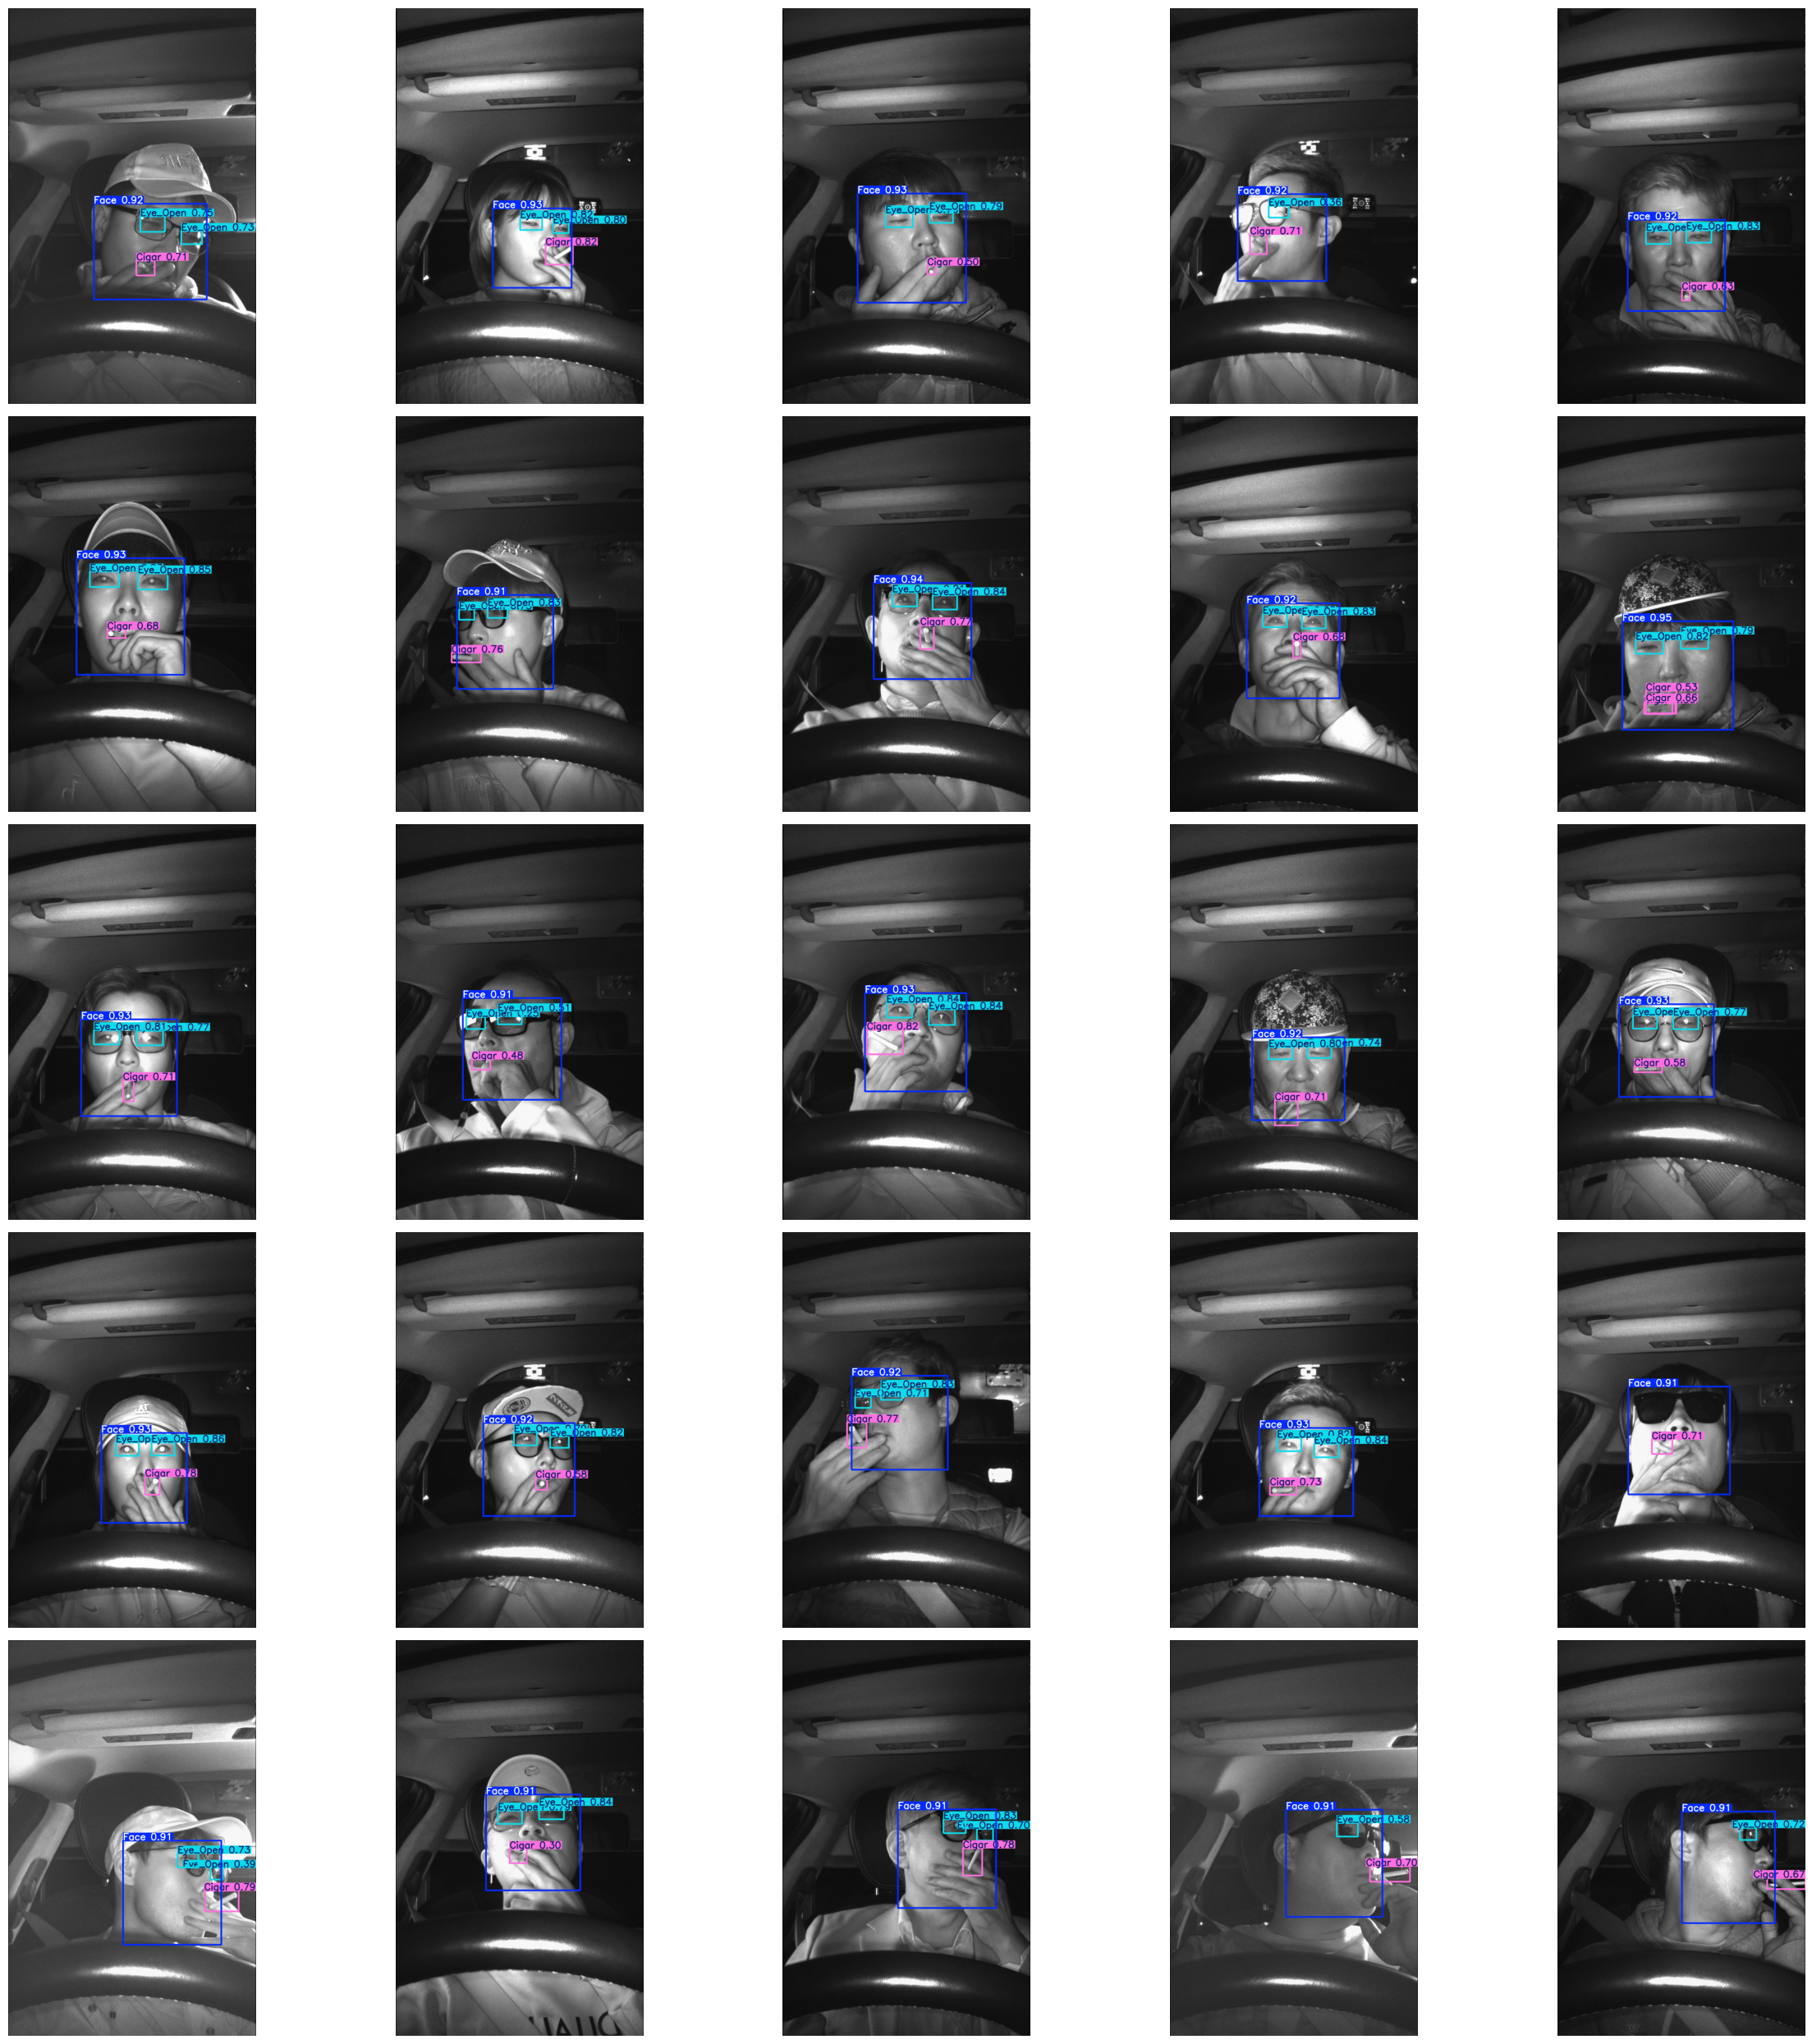

In [22]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Configuration
TEST_IMAGE_DIR = "stratified_dataset/test/images"  # Change to test dataset
NUM_SAMPLES = 25
GRID_SIZE = (5, 5)
FIG_SIZE = (25, 25)

# Class mapping and colors
CLASS_MAP = {
    0: "Cigar",
    1: "Phone"
}

COLORS = {
    "Face": (255, 0, 0),
    "Cigar": (255, 255, 0),
    "Phone": (255, 0, 255)
}

# Load the trained YOLOv8 model
model = YOLO("/kaggle/working/runs/detect/yolov11n_custom_01_2/weights/best.pt")  # Change to your model's path

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Get test images
image_files = [os.path.join(TEST_IMAGE_DIR, f) for f in os.listdir(TEST_IMAGE_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]
image_files = image_files[:NUM_SAMPLES]  # Take a subset for evaluation

# Create a Matplotlib figure
fig, axes = plt.subplots(GRID_SIZE[0], GRID_SIZE[1], figsize=FIG_SIZE)
axes = axes.flatten()

for i, image_path in enumerate(image_files):
    # Run inference
    results = model(image_path)

    # Get the image with detections
    im_array = results[0].plot()  # Plot detections on the image

    # Convert BGR to RGB for Matplotlib
    im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

    # Display in grid
    axes[i].imshow(im_rgb)
    axes[i].axis("off")
    #axes[i].set_title(f"{os.path.basename(image_path)}")

# Hide extra subplots if fewer images than grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
